# Chapter 9
## Spike Frequency Adaptation
- Code by : [Abolfazl Ziaeemehr](https://github.com/Ziaeemehr)

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from input_factory import get_step_current

In [2]:
def plot_data(state_monitor, title=None, c='k', ylim1=(-100, 50), ylim2=None):
    """Plots the state_monitor variables "vm", "w" vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)

    ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c=c)
    ax[1].plot(state_monitor.t / b2.ms, state_monitor.w[0], lw=2, c=c)

    ax[1].set_xlabel("t [ms]")
    ax[0].set_ylabel("v [mV]")
    ax[1].set_ylabel("w")
    ax[0].set_xlim(0, np.max(state_monitor.t / b2.ms))
    ax[0].set_ylim(ylim1)
    ax[0].set_xlim(0, np.max(state_monitor.t / b2.ms))    
    
    if ylim2 is not None:
        ax[1].set_ylim(ylim2)

    if title is not None:
        ax[0].set_title(title)

    plt.show();

### A Model M-Current

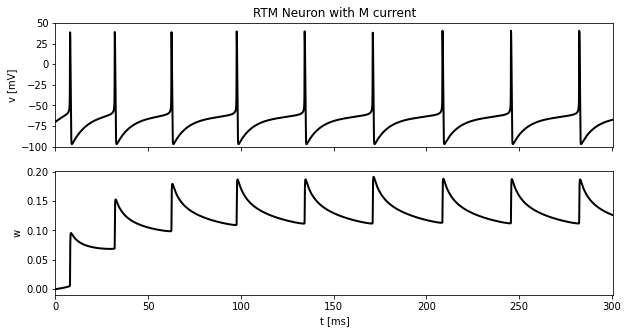

In [3]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory
from numpy import exp


def init(v):
    def alpha_h(v): return 0.128 * exp(-(v + 50.0) / 18.0)
    def alpha_m(v): return 0.32 * (v + 54) / (1.0 - exp(-(v + 54.0) / 4.0))
    def alpha_n(v): return 0.032 * (v + 52) / (1.0 - exp(-(v + 52.0) / 5.0))
    def beta_h(v):  return 4.0 / (1.0 + exp(-(v + 27.0) / 5.0))
    def beta_m(v):  return 0.28 * (v + 27.0) / (exp((v + 27.0) / 5.0) - 1.0)
    def beta_n(v):  return 0.5 * exp(-(v + 57.0) / 40.0)
    def h_inf(v):   return alpha_h(v) / (alpha_h(v) + beta_h(v))
    def m_inf(v):   return alpha_m(v) / (alpha_m(v) + beta_m(v))
    def n_inf(v):   return alpha_n(v) / (alpha_n(v) + beta_n(v))
    
    m = m_inf(v)
    h = h_inf(v)
    n = n_inf(v)
    x0 = [v, m, n, h]
    return x0


def simulate_RTM_M_neuron(input_current, simulation_time):

    """A Reduced Traub-Miles Model neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    gM = 0.25 * b2.msiemens
    C = 1 * b2.ufarad

    # forming RTM model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    
    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz
    
    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz
    
    winf   = 1.0/(1.0+exp(-(vm+35*mV)/(10*mV))) : 1
    tauw = 400/(3.3*exp((vm+35*mV)/(20*mV))+exp(-(vm+35*mV)/(20*mV)))*ms : second
    

    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) + gM*w*(EK-vm) : amp
    
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    dw/dt = (winf - w) / tauw    : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="rk4", dt=0.05*b2.ms)

    # parameter initialization [come from x_inf(v) {x:m,n,h}]
    vm0, m0, n0, h0 = init(-70.0)
    neuron.vm = vm0*b2.mV
    neuron.m = m0
    neuron.h = h0
    neuron.n = n0
    neuron.w = 0.0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "w"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

current = input_factory.get_step_current(0, 301, b2.ms, 1.5 * b2.uA)
state_monitor = simulate_RTM_M_neuron(current, 301 * b2.ms)
plot_data(state_monitor, title="RTM Neuron with M current")


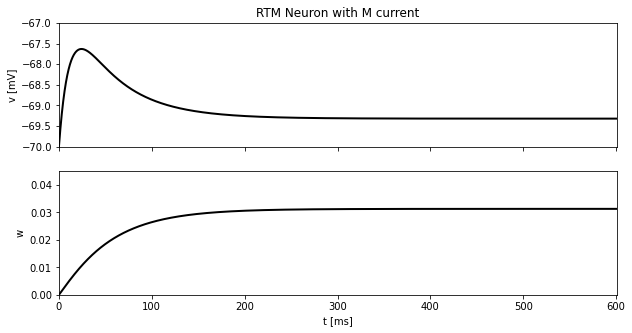

In [4]:
current = input_factory.get_step_current(0, 601, b2.ms, 0.0 * b2.uA)
state_monitor = simulate_RTM_M_neuron(current, 601 * b2.ms)
plot_data(state_monitor, title="RTM Neuron with M current", ylim1=(-70,-67), ylim2=(0,0.045))

### Calcium-Dependent AHP Currents

In [5]:
def plot_data(state_monitor, title=None, c='k', ylim1=(-100, 50), ylim2=None):
    """Plots the state_monitor vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)

    ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c=c)
    ax[1].plot(state_monitor.t / b2.ms, state_monitor.ca[0], lw=2, c=c)

    ax[1].set_xlabel("t [ms]")
    ax[0].set_ylabel("v [mV]")
    ax[1].set_ylabel("ca")
    ax[0].set_xlim(0, np.max(state_monitor.t / b2.ms))
    ax[0].set_ylim(ylim1)
    ax[0].set_xlim(0, np.max(state_monitor.t / b2.ms))    
    
    if ylim2 is not None:
        ax[1].set_ylim(ylim2)

    if title is not None:
        ax[0].set_title(title)

    plt.show();

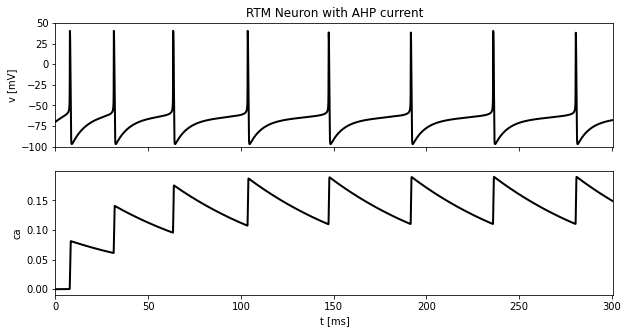

In [6]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory
from numpy import exp


def simulate_RTM_AHP_neuron(input_current, simulation_time):

    """A Reduced Traub-Miles Model neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor
    """

    # neuron parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    gAHP = 0.25 * b2.msiemens
    C = 1 * b2.ufarad

    # forming RTM model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    
    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz
    
    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz
    
    cainf   = 4/25/mV*(120*mV-vm)/(1+exp(-(vm+15*mV)/(5*mV))) : 1    

    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) + gAHP*ca*(EK-vm) : amp
    
    dm/dt = alpham*(1-m)-betam*m  : 1
    dn/dt = alphan*(1-n)-betan*n  : 1
    dh/dt = alphah*(1-h)-betah*h  : 1
    dca/dt = (cainf - ca) / 80/ms : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="rk4", dt=0.05*b2.ms)

    # parameter initialization [come from x_inf(v) {x:m,n,h}]
    vm0, m0, n0, h0 = init(-70.0)
    neuron.vm = vm0*b2.mV
    neuron.m = m0
    neuron.h = h0
    neuron.n = n0
    neuron.ca = 0.0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "ca"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

current = input_factory.get_step_current(0, 301, b2.ms, 1.5 * b2.uA)
state_monitor = simulate_RTM_AHP_neuron(current, 301 * b2.ms)
plot_data(state_monitor, title="RTM Neuron with AHP current")


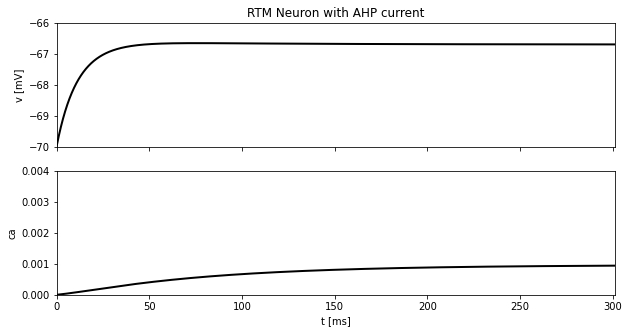

In [11]:
current = input_factory.get_step_current(0, 301, b2.ms, 0.0 * b2.uA)
state_monitor = simulate_RTM_AHP_neuron(current, 301 * b2.ms)
plot_data(state_monitor, title="RTM Neuron with AHP current", ylim1=(-70,-66), ylim2=(0,0.004))
